## Imports

In [1]:
import kagglehub

from matplotlib import pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, hour, date_format

/home/arthur/venv/trabalho-pyspark-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carregando Dados

In [2]:

spark = SparkSession.builder.appName('Exemplo2').config("spark.executor.cores", "4").getOrCreate()

25/01/16 20:50:29 WARN Utils: Your hostname, notebook resolves to a loopback address: 127.0.1.1; using 192.168.18.27 instead (on interface wlp2s0)
25/01/16 20:50:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/16 20:50:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# Download latest version
# path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
# print("Path to dataset files:", path)

df = spark.read.csv('/home/arthur/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13/US_Accidents_March23.csv', header=True, inferSchema=True)

ERROR:root:KeyboardInterrupt while sending command.                (8 + 8) / 23]
Traceback (most recent call last):
  File "/home/arthur/venv/trabalho-pyspark-env/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/venv/trabalho-pyspark-env/lib/python3.12/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/socket.py", line 707, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [69]:
sampled_df = df.sample(withReplacement=False, fraction=0.01)

In [70]:
sampled_df.show()

+------+-------+--------+-------------------+-------------------+------------------+-------------------+-------+-------+------------+--------------------+--------------+-------------------+------------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|    ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|          Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|        Street|               City|      County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather

In [71]:
sampled_df.count()

77437

## Descrição dos Dados

In [5]:
print(f"Número de Linhas: {df.count()}")
print(f"Número de Colunas: {len(df.columns)}")

Número de Linhas: 7728394
Número de Colunas: 46


In [6]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

### Identificação e Origem
ID: Identificador único para cada registro no dataset.

Source: Fonte ou sistema de onde os dados foram obtidos.

### Detalhes do Incidente
Severity: Nível de gravidade do incidente, geralmente representado por um número inteiro.

Start_Time: Data e hora de início do incidente.

End_Time: Data e hora de término do incidente.

Description: Descrição textual do incidente.

### Localização Geográfica
Start_Lat: Latitude do ponto inicial do incidente.

Start_Lng: Longitude do ponto inicial do incidente.

End_Lat: Latitude do ponto final do incidente.

End_Lng: Longitude do ponto final do incidente.

Distance(mi): Distância total do incidente em milhas.

Street: Nome da rua onde o incidente ocorreu.

City: Cidade onde o incidente ocorreu.

County: Condado onde o incidente ocorreu.

State: Estado onde o incidente ocorreu.

Zipcode: Código postal da área onde o incidente ocorreu.

Country: País onde o incidente ocorreu.

Timezone: Fuso horário da localização do incidente.

Airport_Code: Código do aeroporto mais próximo ao local do incidente.


### Condições Climáticas
Weather_Timestamp: Data e hora da coleta das condições meteorológicas.

Temperature(F): Temperatura em graus Fahrenheit no momento do incidente.

Wind_Chill(F): Sensação térmica em graus Fahrenheit.

Humidity(%): Umidade relativa do ar em porcentagem.

Pressure(in): Pressão atmosférica em polegadas de mercúrio.

Visibility(mi): Visibilidade em milhas no momento do incidente.

Wind_Direction: Direção do vento.

Wind_Speed(mph): Velocidade do vento em milhas por hora.

Precipitation(in): Precipitação em polegadas.

Weather_Condition: Condição meteorológica no momento do incidente (e.g., chuva, neve, nublado).


### Condições da Via
Amenity: Indica se havia uma amenidade próxima (True/False).

Bump: Indica se havia um quebra-molas (True/False).

Crossing: Indica se havia uma travessia de pedestres (True/False).

Give_Way: Indica se havia uma sinalização de "Dê a preferência" (True/False).

Junction: Indica se o incidente ocorreu em uma junção (True/False).

No_Exit: Indica se a área era um beco sem saída (True/False).

Railway: Indica se havia uma ferrovia próxima (True/False).

Roundabout: Indica se havia uma rotatória próxima (True/False).

Station: Indica se havia uma estação próxima (True/False).

Stop: Indica se havia uma placa de parada próxima (True/False).

Traffic_Calming: Indica se havia medidas de acalmia de tráfego (True/False).

Traffic_Signal: Indica se havia semáforos próximos (True/False).

Turning_Loop: Indica se havia um retorno próximo (True/False).


### Condições de Luminosidade

Sunrise_Sunset: Indica se o incidente ocorreu durante o nascer ou pôr do sol.

Civil_Twilight: Período de crepúsculo civil (luz solar indireta).

Nautical_Twilight: Período de crepúsculo náutico (horizonte visível ao mar).

Astronomical_Twilight: Período de crepúsculo astronômico (pouca ou nenhuma luz solar).


## Tratamento dos Dados

#### Check NAs

In [7]:
df_nulls = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

df_nulls_pandas = df_nulls.toPandas()

df_nulls_pandas_perc = 100* (df_nulls_pandas.T / df.count())

df_nulls_pandas_perc.map('{:.2f}%'.format)

,0
ID,0.00%
Source,0.00%
Severity,0.00%
Start_Time,0.00%
End_Time,0.00%
Start_Lat,0.00%
Start_Lng,0.00%
End_Lat,44.03%
End_Lng,44.03%
Distance(mi),0.00%


### Drop NAs

In [8]:
columns = df.columns
cols_to_remove = ['End_Lat','End_Lng', 'Wind_Chill(F)', 'Precipitation(in)']
cols_to_drop = [c for c in columns if c not in cols_to_remove ]

df_cleaned_subset = df.dropna(subset=cols_to_drop)

df_cleaned_subset.show()

+----+-------+--------+-------------------+-------------------+------------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|A

In [9]:
df_cleaned_subset.count()

7051556

In [10]:
sampled_df = df_cleaned_subset.sample(withReplacement=False, fraction=0.1)

sampled_df.show()

+-----+-------+--------+-------------------+-------------------+------------------+------------------+-------+-------+------------+--------------------+----------------+-----------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|   ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|          Street|       City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| 

## Análise Exploratória

In [11]:
def barplot(data, builder, table_name, query, hue=False):

    data.createOrReplaceTempView(f"{table_name}")

    data_agg = builder.sql(
        query
    )

    data_agg_toPandas = data_agg.toPandas()

    if hue:
        return sns.barplot(data=data_agg_toPandas, x = data_agg_toPandas[data_agg_toPandas.columns[0]], y = data_agg_toPandas[data_agg_toPandas.columns[-1]], hue = data_agg_toPandas[data_agg_toPandas.columns[1]])
    else:
        return sns.barplot(data=data_agg_toPandas, x = data_agg_toPandas[data_agg_toPandas.columns[0]], y = data_agg_toPandas[data_agg_toPandas.columns[-1]])

In [58]:
def histplot(data, builder, table_name, query, hue=False):

    data.createOrReplaceTempView(f"{table_name}")

    data_agg = builder.sql(
        query
    )

    data_agg_toPandas = data_agg.toPandas()

    if hue:
        return sns.histplot(data=data_agg_toPandas, x = data_agg_toPandas[data_agg_toPandas.columns[0]], hue = data_agg_toPandas[data_agg_toPandas.columns[1]], multiple = 'fill')
    else:
        return sns.histplot(data=data_agg_toPandas, x = data_agg_toPandas[data_agg_toPandas.columns[0]], multiple='fill')

<Axes: xlabel='Severity', ylabel='count(1)'>

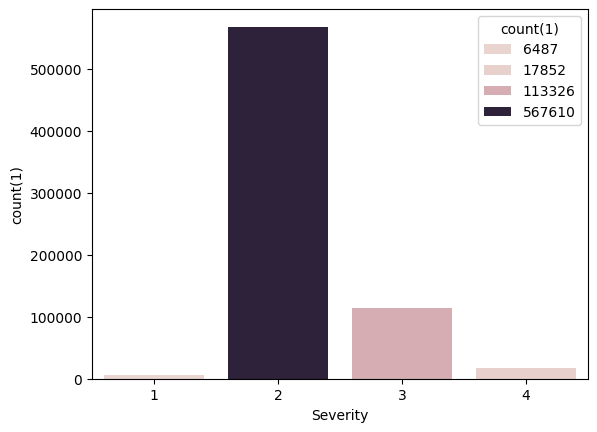

In [13]:
barplot(
    data = sampled_df,
    builder = spark,
    table_name= 'acidents',
    query = '''
        SELECT
            Severity,
            COUNT(*)
        FROM acidents
        GROUP BY 1
        ORDER BY 1
    ''',
    hue=True)

<Axes: xlabel='wind', ylabel='Density'>

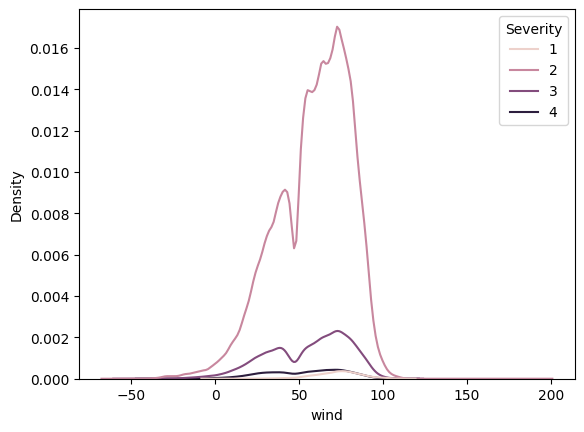

In [19]:
histplot(
    data = sampled_df,
    builder = spark,
    table_name= 'acidents',
    query = '''
    SELECT
        ROUND(`Wind_Chill(F)`,0) AS wind,
        Severity
    FROM acidents
    ORDER BY 1
    ''',
    hue=True)

In [22]:
sampled_df.show()

+-----+-------+--------+-------------------+-------------------+------------------+------------------+-------+-------+------------+--------------------+----------------+-----------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|   ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|          Street|       City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| 

In [24]:
potencial_columns = [
'ID',
 'Severity',
 'Start_Time',
 'End_Time',
 'Zipcode',
 'Weather_Timestamp',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Direction',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Weather_Condition',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop',
 'Sunrise_Sunset',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight'
 ]

## Feature Engeneering

In [40]:
sampled_select_columns = sampled_df.select(*potencial_columns)

In [52]:
# Extrai o dia da semana
sampled_select_columns = sampled_select_columns.withColumn("day_of_week", date_format(col("Start_Time"), "F"))

# Extrai a hora do dia
sampled_select_columns = sampled_select_columns.withColumn("hour_of_day", hour(col("Start_Time")))

In [53]:
sampled_select_columns.show()

+-----+--------+-------------------+-------------------+----------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|   ID|Severity|         Start_Time|           End_Time|   Zipcode|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|day_of_week|hour_of_day|
+-----+--------+-------------------+-------------------+----------+-------------------+--------------+----------

## Separação do Treino e Teste

## Preparar os Dados de Treino
- Transformar as categorias 
- Padronizar, normalizar e etc

## Preparar os Dados de Teste

## Testar os Modelos

- SVM
- KNN
- Random Forest 

## Avaliar Modelo
- Cross Validation

## Avaliar o melhor modelo